In [16]:
import math 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import itertools

# Sklearn imports
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from multi_freq_ldpy.pure_frequency_oracles.GRR import GRR_Client
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
# LDP import
from GRR import GRR_Client
from GroupFairnessNotions import confusion_matrix_scorer, Statistical_parity, Metric_disparity, Equal_opportunity, Predictive_equality, Treatment_equality, Overall_accuracy, Predictive_rate_parity, CSD

In [18]:
# Evaluating nb_seed times due to randomness
nb_seed = 20

dataset = 'Synthetic2'
path_results = 'Results/'

# list of epsilon
#[8,2,1,0.8,0.5,0.40,0.27,0.2,0.1]
lst_eps = [16,8,2,1,0.85,0.5,0.40,0.27,0.23,0.1]

# Target attribute
target = 'Y' 

# Protected attribute 
protected_att = 'A'

test_size = 0.2

nb_samples = 1e5

lst_sensitive = [protected_att,'X']

## Case 1:  P(A=1) = 0.7, P(X=1)=0.5, X = 1 or A = 1 --> Y=1


A = 1 is majority , P(Y=1, A=1) > P(Y=0, A=1), P(Y=1, A=0) = P(Y=0,A=0)

In [4]:
def generate_synthetic_data(p,n):
    X = np.random.binomial(1,p,n)
    A = [np.random.binomial(1,0.55,1)[0] if x ==0 else np.random.binomial(1,0.75,1)[0] for x in X]
    #Y = [0.5*x + 0.75*a + np.random.normal(size=1) [0] for x,a in zip(X,A)]
    df = pd.DataFrame({'X': X, 'A': A})
    return df

In [5]:
df = generate_synthetic_data(0.5,100000)

In [6]:
df['Y'] = df.apply(lambda row: int(row.A == 1 or row.X == 1), axis = 1)

In [7]:
df.Y.value_counts()

1    77265
0    22735
Name: Y, dtype: int64

## Data Distribution

In [14]:
print(df.Y.value_counts())
A0_Y0 = len(df[(df['A'] == 0) & (df['Y'] == 0)])
A0_Y1 = len(df[(df['A'] == 0) & (df['Y'] == 1)])
A1_Y0 = len(df[(df['A'] == 1) & (df['Y'] == 0)])
A1_Y1 = len(df[(df['A'] == 1) & (df['Y'] == 1)])
print(f'A0_Y0: {A0_Y0}\n A0_Y1: {A0_Y1}\n A1_Y0: {A1_Y0}\n A1_Y1: {A1_Y1}')

1    77575
0    22425
Name: Y, dtype: int64
A0_Y0: 22425
 A0_Y1: 12396
 A1_Y0: 0
 A1_Y1: 65179


In [8]:
print(df.X.value_counts())
A0_X0_Y0 = len(df[(df['A'] == 0) & (df['X'] == 0) & (df['Y'] == 0)])
A0_X1_Y0 = len(df[(df['A'] == 0) & (df['X'] == 1) & (df['Y'] == 0)])
A1_X0_Y0 = len(df[(df['A'] == 1) & (df['X'] == 0) & (df['Y'] == 0)])
A1_X1_Y0 = len(df[(df['A'] == 1) & (df['X'] == 1) & (df['Y'] == 0)])
A0_X0_Y1 = len(df[(df['A'] == 0) & (df['X'] == 0) & (df['Y'] == 1)])
A0_X1_Y1 = len(df[(df['A'] == 0) & (df['X'] == 1) & (df['Y'] == 1)])
A1_X0_Y1 = len(df[(df['A'] == 1) & (df['X'] == 0) & (df['Y'] == 1)])
A1_X1_Y1 = len(df[(df['A'] == 1) & (df['X'] == 1) & (df['Y'] == 1)])

print(f'A0_X0_Y0: {A0_X0_Y0}\n A0_X1_Y0: {A0_X1_Y0}\n A1_X0_Y0: {A1_X0_Y0}\n A1_X1_Y0: {A1_X1_Y0}\n A0_X0_Y1: {A0_X0_Y1}\n A0_X1_Y1: {A0_X1_Y1}\n A1_X0_Y1: {A1_X0_Y1}\n A1_X1_Y1: {A1_X1_Y1}\n')




0    50050
1    49950
Name: X, dtype: int64
A0_X0_Y0: 22735
 A0_X1_Y0: 0
 A1_X0_Y0: 0
 A1_X1_Y0: 0
 A0_X0_Y1: 0
 A0_X1_Y1: 12232
 A1_X0_Y1: 27315
 A1_X1_Y1: 37718



## Computation of the epsilon where the change starts (theoritically)

In [16]:
delta1_X0 = A1_X0_Y1 - A1_X0_Y0
delta0_X0 = A0_X0_Y1 - A0_X0_Y0
epsilon_CSD_X0 = np.log(-(delta1_X0/delta0_X0))

In [17]:
epsilon_CSD_X0

0.195888027861143

In [18]:
delta1_X1 = A1_X1_Y1 - A1_X1_Y0
delta0_X1 = A0_X1_Y1 - A0_X1_Y0
epsilon_CSD_X1 = np.log(-(delta1_X1/delta0_X1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
A0 = len(df[(df['A'] == 0)])/len(df)
A1 = len(df[(df['A'] == 1)])/len(df)
X1 = len(df[(df['X'] == 1)])/len(df)
X0 = len(df[(df['X'] == 0)])/len(df)

# Non-private Random Forest (using train/test splitting)

In [24]:
np_sp_min1, np_sp_maj1, np_sd = [], [], []
np_acc1 = []
np_oa_min1, np_oa_maj1, np_oad = [], [], []
ndp_csp_minX0, ndp_csp_majX0, np_csd_X0, ndp_csp_minX1, ndp_csp_majX1, np_csd_X1 = [], [] ,[] , [],[], []
np_eo_min1, np_eo_maj1, np_eod = [], [], []
np_pe_min1, np_pe_maj1, np_ped = [], [], []


for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # for reproducibility
    
    # Use original datasets
    X = copy.deepcopy(df.drop(target, axis=1))
    y = copy.deepcopy(df[target])

    # Train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)
    
    # instantiate and train model
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # retrieving minority, majority from the test set
    X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

    # predicted outcomes for minority, majority
    y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

    indices_min, indices_maj = X_test_min.index, X_test_maj.index
    y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)
    
    # Needed for the computation of Cond.Stat.Disp
            
    # retrieving four groups: A=0_X=0, A0_X=1, A1_X=0, A1_X=1 from the test set

    X_test_min_X0, X_test_min_X1, X_test_maj_X0, X_test_maj_X1 = X_test[(X_test[protected_att] == 0) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 1)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 1)]
    
    
    # confusion matrix for minority, majority
    conf_matrix_min, conf_matrix_maj = confusion_matrix_scorer(y_test_min,y_pred_min), confusion_matrix_scorer(y_test_maj,y_pred_maj)
    
    # predicted outcomes for the four groups
    y_pred_min_X0, y_pred_min_X1, y_pred_maj_X0, y_pred_maj_X1 = model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_maj_X0), model.predict(X_test_maj_X1)  
#     pred_A0_X0.append(y_pred_min_X0)
#     pred_A0_X1.append(y_pred_min_X1)
#     pred_A1_X0.append(y_pred_min_X0)
#     pred_A1_X1.append(y_pred_maj_X1)
    
    # computing fairness metrics
    np_sp_min1.append(Statistical_parity(y_pred_min))
    np_sp_maj1.append(Statistical_parity(y_pred_maj))
    np_sd.append(Metric_disparity(Statistical_parity(y_pred_maj), Statistical_parity(y_pred_min)))
    np_eo_min1.append(Equal_opportunity(conf_matrix_min))
    np_eo_maj1.append(Equal_opportunity(conf_matrix_maj))
    np_eod.append(Metric_disparity(Equal_opportunity(conf_matrix_maj), Equal_opportunity(conf_matrix_min)))
    np_pe_min1.append(Predictive_equality(conf_matrix_min))
    np_pe_maj1.append(Predictive_equality(conf_matrix_maj))
    np_ped.append(Metric_disparity(Predictive_equality(conf_matrix_maj), Predictive_equality(conf_matrix_min)))
    ndp_csp_minX0.append(Statistical_parity(y_pred_min_X0))
    ndp_csp_majX0.append(Statistical_parity(y_pred_maj_X0))
    np_csd_X0.append(Metric_disparity(Statistical_parity(y_pred_maj_X0), Statistical_parity(y_pred_min_X0)))
    ndp_csp_minX1.append(Statistical_parity(y_pred_min_X1))
    ndp_csp_majX1.append(Statistical_parity(y_pred_maj_X1))  
    np_csd_X1.append(Metric_disparity(Statistical_parity(y_pred_maj_X1), Statistical_parity(y_pred_min_X1)))
    np_oa_min1.append(Overall_accuracy(y_test_min, y_pred_min))
    np_oa_maj1.append(Overall_accuracy(y_test_maj, y_pred_maj))
    np_oad.append(Metric_disparity(Overall_accuracy(y_test_maj, y_pred_maj), Overall_accuracy(y_test_min, y_pred_min)))
    np_acc1.append(acc)


0


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


1


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


2


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


3


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


4


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


5


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


6


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


7


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


8


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


9


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


10


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


11


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


12


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


13


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


14


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


15


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


16


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


17


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


18


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


19


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


In [25]:
print("\n=======================================No DP=======================================\n")

print('Non-Private fairness notions considering the protected attribute '+str(protected_att)+':')
print("The predicted acceptance rate (statistical parity) for A=0 is:", np.mean(np_sp_min1))
print("The predicted acceptance rate (statistical parity) for A=1 is:", np.mean(np_sp_maj1))
print("The true positive rate (Equal Opporunity) for A=0 is:", np.mean(np_eo_min1))
print("The true positive rate (Equal Opporunity) for A=1 is:", np.mean(np_eo_maj1))
print("The false positive rate (Predictive Equality) for A=0 is:", np.mean(np_pe_min1))
print("The false positive rate (Predictive Equality) for A=1 is:", np.mean(np_pe_maj1))
print("The conditional acceptance rate for A=0/X=0 is:", np.mean(ndp_csp_minX0))
print("The conditional acceptance rate for A=1/X=0 is:", np.mean(ndp_csp_majX0)) 
print("The conditional acceptance rate for A=0/X=1 is:", np.mean(ndp_csp_minX1))
print("The conditional acceptance rate for A=1/X=1 is:", np.mean(ndp_csp_majX1))
print("The overall accuracy for A=0 is:", np.mean(np_oa_min1))
print("The overall accuracy for A=1 is:", np.mean(np_oa_maj1))
print("The overall accuracy is:", np.mean(np_acc1))


=======================================No DP=======================================

Non-Private fairness notions considering the protected attribute A:
The predicted acceptance rate (statistical parity) for A=0 is: 0.40637070843399636
The predicted acceptance rate (statistical parity) for A=1 is: 1.0
The true positive rate (Equal Opporunity) for A=0 is: 1.0
The true positive rate (Equal Opporunity) for A=1 is: 1.0
The false positive rate (Predictive Equality) for A=0 is: 0.0
The false positive rate (Predictive Equality) for A=1 is: nan
The conditional acceptance rate for A=0/X=0 is: 0.0
The conditional acceptance rate for A=1/X=0 is: 1.0
The conditional acceptance rate for A=0/X=1 is: 1.0
The conditional acceptance rate for A=1/X=1 is: 1.0
The overall accuracy for A=0 is: 1.0
The overall accuracy for A=1 is: 1.0
The overall accuracy is: 1.0


# Starting with Local Differential Privacy

In [26]:
starttime = time.time()
print("\n========= Setting 1: Local DP: only the sensitive feature is obfuscated =========\n")

df_cp = copy.deepcopy(df)

sldp_sp_min1, sldp_sp_maj1, sldp_sd, sd_std  = [], [], [], []
sldp_csp_minX0, sldp_csp_majX0, sldp_csd_X0, csd_X0_std, sldp_csp_minX1, sldp_csp_majX1, sldp_csd_X1, csd_X1_std = [], [] , [], [], [],[], [], []
sldp_oa_min1, sldp_oa_maj1, sldp_oad, oad_std = [], [], [], []
sldp_eo_min1, sldp_eo_maj1, sldp_eod, eod_std = [], [], [], []
sldp_pe_min1, sldp_pe_maj1, sldp_ped, ped_std = [], [], [], []
sldp_acc1 = []



for epsilon in lst_eps:
    print(epsilon)
    
    ldp_sp_min, ldp_sp_maj, ldp_sd = [], [], []
    ldp_csp_minX0, ldp_csp_majX0, ldp_csd_X0, ldp_csp_minX1, ldp_csp_majX1,ldp_csd_X1 = [], [],[], [], [], []
    ldp_acc = []
    ldp_oa_min, ldp_oa_maj, ldp_oad  = [], [], []
    ldp_eo_min, ldp_eo_maj, ldp_eod  = [], [], []
    ldp_pe_min, ldp_pe_maj, ldp_ped = [], [], []
    
    for seed in range(nb_seed):
        #np.random.seed(seed)


        # Preparing X and y using pandas
        X = copy.deepcopy(df_cp.drop(target, axis=1))
        y = copy.deepcopy(df_cp[target])

        # Train test splitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)

        # Attribute's domain size
        k = len(set(X[protected_att]))

        # Applying GRR to the protected attribute of the training set
        X_train[protected_att] = X_train[protected_att].apply(lambda x: GRR_Client(x, k, epsilon))
        
        # instantiate and train model
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test) # prediction of the actual samples
        
        acc = accuracy_score(y_test, y_pred)

        # retrieving minority, majority from the test set
        X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

        # predicted outcomes for minority, majority
        y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

        indices_min, indices_maj = X_test_min.index, X_test_maj.index
        y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)
        
        
        # Needed for the computation of Cond.Stat.Disp
            
        # retrieving four groups: A=0_X=0, A0_X=1, A1_X=0, A1_X=1 from the test set
            
        X_test_min_X0, X_test_min_X1, X_test_maj_X0, X_test_maj_X1 = X_test[(X_test[protected_att] == 0) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 1)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 1)]
        
        # confusion matrix for minority, majority
        conf_matrix_min, conf_matrix_maj = confusion_matrix_scorer(y_test_min,y_pred_min), confusion_matrix_scorer(y_test_maj,y_pred_maj)

        
        # predicted outcomes for the four groups
        y_pred_min_X0, y_pred_min_X1, y_pred_maj_X0, y_pred_maj_X1 = model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_maj_X0), model.predict(X_test_maj_X1)  
#         pred_A0_X0.append(y_pred_min_X0)
#         pred_A0_X1.append(y_pred_min_X1)
#         pred_A1_X0.append(y_pred_min_X0)
#         pred_A1_X1.append(y_pred_maj_X1)
        # computing fairness metrics with obfuscated A
        ldp_sp_min.append(Statistical_parity(y_pred_min))
        ldp_sp_maj.append(Statistical_parity(y_pred_maj))
        ldp_sd.append(Metric_disparity(Statistical_parity(y_pred_maj), Statistical_parity(y_pred_min)))
        
        ldp_eo_min.append(Equal_opportunity(conf_matrix_min))   
        ldp_eo_maj.append(Equal_opportunity(conf_matrix_maj))
        ldp_eod.append(Metric_disparity(Equal_opportunity(conf_matrix_maj), Equal_opportunity(conf_matrix_min)))
        
        ldp_pe_min.append(Predictive_equality(conf_matrix_min))
        ldp_pe_maj.append(Predictive_equality(conf_matrix_maj))
        ldp_ped.append(Metric_disparity(Predictive_equality(conf_matrix_maj), Predictive_equality(conf_matrix_min)))
        
        ldp_csp_minX0.append(Statistical_parity(y_pred_min_X0))
        ldp_csp_majX0.append(Statistical_parity(y_pred_maj_X0))
        ldp_csd_X0.append(Metric_disparity(Statistical_parity(y_pred_maj_X0), Statistical_parity(y_pred_min_X0)))
        
        ldp_csp_minX1.append(Statistical_parity(y_pred_min_X1))
        ldp_csp_majX1.append(Statistical_parity(y_pred_maj_X1))
        ldp_csd_X1.append(Metric_disparity(Statistical_parity(y_pred_maj_X1), Statistical_parity(y_pred_min_X1)))
        
        ldp_oa_min.append(Overall_accuracy(y_test_min, y_pred_min))
        ldp_oad.append(Metric_disparity(Overall_accuracy(y_test_maj, y_pred_maj), Overall_accuracy(y_test_min, y_pred_min)))
        
        ldp_oa_maj.append(Overall_accuracy(y_test_maj, y_pred_maj))        
        ldp_acc.append(acc)

    print(np.mean(ldp_sp_min))  
    sldp_sp_min1.append(np.mean(ldp_sp_min))
    sldp_sp_maj1.append(np.mean(ldp_sp_maj))
    sldp_sd.append(np.mean(ldp_sd))
    sd_std.append(np.std(sldp_sd))
    sldp_csp_minX0.append(np.mean(ldp_csp_minX0))
    sldp_csp_majX0.append(np.mean(ldp_csp_majX0))
    sldp_csd_X0.append(np.mean(ldp_csd_X0))
    csd_X0_std.append(np.std(sldp_csd_X0))
    sldp_csp_minX1.append(np.mean(ldp_csp_minX1))
    sldp_csp_majX1.append(np.mean(ldp_csp_majX1))
    sldp_csd_X1.append(np.mean(ldp_csd_X1))
    csd_X1_std.append(np.std(sldp_csd_X1))
    sldp_oa_min1.append(np.mean(ldp_oa_min))
    sldp_oa_maj1.append(np.mean(ldp_oa_maj))
    sldp_oad.append(np.mean(ldp_oad))
    oad_std.append(np.std(sldp_oad))
    sldp_eo_min1.append(np.mean(ldp_eo_min))
    sldp_eo_maj1.append(np.mean(ldp_eo_maj))
    sldp_eod.append(np.mean(ldp_eod))
    eod_std.append(np.std(sldp_eod))
    sldp_pe_min1.append(np.mean(ldp_pe_min))
    sldp_pe_maj1.append(np.mean(ldp_pe_maj))
    sldp_ped.append(np.mean(ldp_ped))
    ped_std.append(np.std(sldp_ped))
    sldp_acc1.append(np.mean(ldp_acc))
    
#print(sldp_sp_min1)
    
print('That took {} seconds'.format(time.time() - starttime)) 



========= Setting 1: Local DP: only the sensitive feature is obfuscated =========

16


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
8


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
2


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
1


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
0.85


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
0.5


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
0.4


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
0.27


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
0.23


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

0.40637070843399636
0.1


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)
/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:5

1.0
That took 402.51374983787537 seconds


/Users/karima/GoogleDrive/KarimaWork/PhD_Third_Year/Research/Privacy_Fairness/Theoritical_Work/Experiments/GroupFairnessNotions.py:59: RuntimeWarning: invalid value encountered in true_divide
  return FP/float(FP+TN)


In [27]:
print(f'SP for Majority, no LDP {np.mean(np_sp_maj1)}\t, sLDP {sldp_sp_maj1}\n SP for Minority, no LDP {np.mean(np_sp_min1)}\t, sLDP {sldp_sp_min1}')

print(f'CSP for Majority_X0, no LDP {np.mean(ndp_csp_majX0)}\t, sLDP {sldp_csp_majX0}\n CSP for Minority_X0, no LDP {np.mean(ndp_csp_minX0)}\t, sLDP {sldp_csp_minX0}')

print(f'CSP for Majority/X1, no LDP {np.mean(ndp_csp_majX1)}\t, sLDP {sldp_csp_majX1}\n CSP for Minority/X1, no LDP {np.mean(ndp_csp_minX1)}\t, sLDP {sldp_csp_minX1}')                                    

print(f'Accuracy for Majority, no LDP {np.mean(np_oa_maj1)}\t, sLDP {sldp_oa_maj1}\n Accuracy for Minority, no LDP {np.mean(np_oa_min1)}\t, sLDP {sldp_oa_min1}')

print(f'EO for Majority, no LDP {np.mean(np_eo_maj1)}\t, sLDP {sldp_eo_maj1}\n EO for Minority, no LDP {np.mean(np_eo_min1)}\t, sLDP {sldp_eo_min1}')

print(f'PE for Majority, no LDP {np.mean(np_pe_maj1)}\t, sLDP {sldp_pe_maj1}\n PE for Minority, no LDP {np.mean(np_pe_min1)}\t, sLDP {sldp_pe_min1}')



SP for Majority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 SP for Minority, no LDP 0.40637070843399636	, sLDP [0.40637070843399636, 0.40637070843399636, 0.40637070843399636, 0.40637070843399636, 0.40637070843399636, 0.40637070843399636, 0.40637070843399636, 0.40637070843399636, 0.40637070843399636, 1.0]
CSP for Majority_X0, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 CSP for Minority_X0, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
CSP for Majority/X1, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 CSP for Minority/X1, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy for Majority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 Accuracy for Minority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.40637070843399636]
EO for Majority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 EO for Minority, 

## Visualization

In [41]:
def Make_subplots_2(lst_eps,dataset_name):    
    fig2, ax2 = plt.subplots(1, 2, figsize=(10, 5),sharex='col', sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.yticks(fontsize=9)
    
    #ax2[0].axhline(y=np.mean(np_sp_maj1)-np.mean(np_sp_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_sd,sd_std,color='forestgreen', ecolor='forestgreen',label='SD',fmt='o',markersize=3)
    #ax2[0].errorbar(x,ldp_ind_spd2,std_values_indldp2['SPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)            
    ax2[0].plot(sldp_sd,color='forestgreen', label='SD',marker='o', fillstyle='none')
    plt.annotate("Baseline", (lst_eps[0], np.mean(np_sp_maj1)-np.mean(np_sp_min1)))
    
    #ax2[1].axhline(y=np.mean(ndp_csp_majX0)-np.mean(ndp_csp_minX0), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X0,csd_X0_std,color='red', ecolor='red',label='CSD_x0',fmt='D',markersize=3)
    ax2[0].plot(sldp_csd_X0,color='red',label='CSD_x0',marker='D', fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(ndp_csp_majX1)-np.mean(ndp_csp_minX1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X1,csd_X1_std,color='orange', ecolor='orange',label='CSD_x1',fmt='-o',markersize=3)
    ax2[0].plot(sldp_csd_X1,color='orange', label='CSD_x1',marker='X', fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(np_eo_maj1)-np.mean(np_eo_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_eod,eod_std,color='blue', ecolor='blue',label='EOD',fmt='-o',markersize=3, alpha=0.4)
    ax2[0].plot(sldp_eod,color='blue', label='EOD',marker='v', alpha=0.4, fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(np_sp_maj1)-np.mean(np_sp_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_sd,sd_std,color='forestgreen', ecolor='forestgreen',label='SD',fmt='o',markersize=3)
    #ax2[0].errorbar(x,ldp_ind_spd2,std_values_indldp2['SPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)            
    ax2[1].plot(sldp_sd,color='forestgreen', label='SD',marker='o',markersize=3, fillstyle='none')
    
    
    #ax2[1].axhline(y=np.mean(ndp_csp_majX0)-np.mean(ndp_csp_minX0), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X0,csd_X0_std,color='red', ecolor='red',label='CSD_x0',fmt='D',markersize=3)
    ax2[1].plot(sldp_csd_X0,color='red',label='CSD_x0',marker='D',markersize=3)
    
    #ax2[0].axhline(y=np.mean(ndp_csp_majX1)-np.mean(ndp_csp_minX1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X1,csd_X1_std,color='orange', ecolor='orange',label='CSD_x1',fmt='-o',markersize=3)
    ax2[1].plot(sldp_csd_X1,color='orange', label='CSD_x1',marker='X',markersize=3)
    
    #ax2[0].axhline(y=np.mean(np_eo_maj1)-np.mean(np_eo_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_eod,eod_std,color='blue', ecolor='blue',label='EOD',fmt='-o',markersize=3, alpha=0.4)
    ax2[1].plot(sldp_eod,color='blue', label='EOD',marker='v',markersize=3, alpha=0.4)
    
     
        
#     ax2[4].axhline(y=np.mean(np_pe_maj1)-np.mean(np_pe_min1), color='black', label = 'noLDP')
#     ax2[4].errorbar(x,sldp_ped,ped_std,color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     #ax2[2].errorbar(x,ldp_ind_ped2,std_values_indldp2['PED'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
    
#     ax2[5].axhline(y=np.mean(np_oa_maj1)-np.mean(np_oa_min1), color='black', label = 'noLDP')
#     ax2[5].errorbar(x,sldp_oad,oad_std,color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     #ax2[3].errorbar(x,ldp_ind_oad2,std_values_indldp2['OAD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
    
#     ax2[4].axhline(y=PRP_maj_mean2-PRP_min_mean2, color='black', label = 'noLDP')
#     ax2[4].errorbar(x,allsldp_prpd2,std_values_comldp2['PRPD'],color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     ax2[4].errorbar(x,ldp_ind_prpd2,std_values_indldp2['PRPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
 
    #ax2[0].set_title('Synthetic 2 \n No $X \perp A$',fontsize=12)
    ax2[1].set_title('Synthetic 2 \n ',fontsize=12)
#     ax2[2].set_title('CSD_x1',fontsize=12)
#     ax2[3].set_title('EOD',fontsize=12)
#     ax2[4].set_title('PED',fontsize=12)
#     ax2[5].set_title('OAD',fontsize=12)
#     ax2[4].set_title('PRD',fontsize=12)


    for j in range(2):
        ax2[j].set_xticks(range(len(lst_eps)))        
        ax2[j].set_xticklabels(lst_eps,fontsize=9)
        ax2[j].set_xlabel('$\epsilon$', fontsize=12)   
        ax2[j].grid(axis='y')
        ax2[j].legend(fontsize='8')
    # saving the plot as a pdf file
    fig2.savefig(path_results + dataset + '.pdf',dpi=100,bbox_inches='tight')
    
    return fig2.show()

In [42]:
x = range(len(lst_eps))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


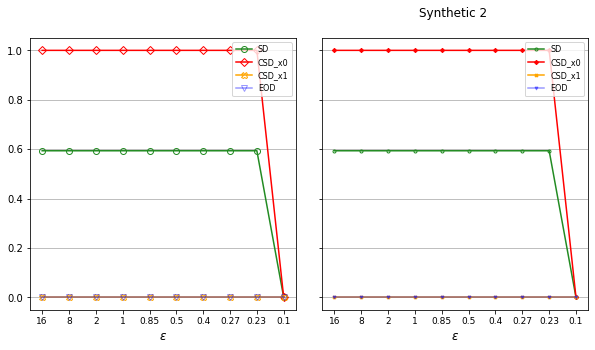

In [43]:
Make_subplots_2(lst_eps,'Synthetic2')

In [124]:
csd_X0_std

[0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.3818813079129867,
 0.4403152859263555,
 0.46351240544347894,
 0.4714045207910317,
 0.47169905660283024]

In [60]:
sldp_sd

[0.003759694105249853,
 0.003759694105249853,
 0.003759694105249853,
 0.003759694105249853,
 0.22862801266543287,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

## Case 2:  P(A=1) = 0.7, P(X=0.5), X = 1 and A = 1 --> Y=1


A = 1 is majority , P(Y=1, A=1) = P(Y=0, A=1), P(Y=1, A=0) < P(Y=0,A=0)

P(A=1) = 0.7, P(Y=1 | A=1) = 0.7, P(Y=1 | A=0) = 0.3 (far from each other)

1- Obfuscating A only: 
    
* P(Y^hat = 1 | A=0 ) increased from 0 to [0.0, 0.0, 0.0, 0.37700604343338356, 0.502138002684527, 0.502138002684527, 0.502138002684527, 0.502138002684527]
                 
* P(Y^hat = 1 | A=1 ) stayed unchanged: 0.4993481673823865

2- Obfuscation of A and X independetly:

* P(Y^hat = 1 | A=0 ) stayed unchanged: 0

* P(Y^hat = 1 | A=1 ) decreased from 0.4993481673823865 to  [0.4993481673823865, 0.4993481673823865, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

3- Obfuscation of A and X combined:

* P(Y^hat = 1 | A=0 ) stayed unchanged: 0

* P(Y^hat = 1 | A=1 ) decreased from 0.4993481673823865 [0.4993481673823865, 0.4993481673823865, 0.4993481673823865, 0.4993481673823865, 0.0, 0.0, 0.0, 0.0]
                 

# 1- P(A=1) = 0.7, P(X=0.5), X = 1 and A = 1 --> Y=1

In [18]:
x0, x1 = 0.5, 0.5
a0, a1 = 0.3, 0.7 


p_a0_x0 = np.rint(a0 * x0 * nb_samples).astype(int)
p_a0_x1 = np.rint(a0 * x1 * nb_samples).astype(int)
p_a1_x0 = np.rint(a1 * x0 * nb_samples).astype(int)
p_a1_x1 = np.rint(a1 * x1 * nb_samples).astype(int)


print(p_a0_x0, p_a0_x1, p_a1_x0, p_a1_x1)
orig_nb_samples = [p_a0_x0, p_a0_x1, p_a1_x0, p_a1_x1]
print (sum(orig_nb_samples))


15000 15000 35000 35000
100000


In [19]:
# creating a list of column names
column_values = ['A','X']

# creating the patterns of features
pattern_features = [x for x in itertools.product([0, 1], repeat=len(column_values))]

# creating the dataframe
df = pd.DataFrame(data = pattern_features, 
                  columns = column_values)
  
# displaying the dataframe
display(df)

,A,X
0,0,0
1,0,1
2,1,0
3,1,1


In [20]:
df['n'] = orig_nb_samples
df = df.loc[df.index.repeat(df.n)].reset_index(drop=True)
del df['n']
display(df)

,A,X
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,1,1
99996,1,1
99997,1,1
99998,1,1


In [21]:
df['Y'] = df.apply(lambda row: int(row.A == 1 and row.X == 1), axis = 1)

In [22]:
df.Y.value_counts()
A0 = len(df[(df['A'] == 0)])/len(df)
A1 = len(df[(df['A'] == 1)])/len(df)
X1 = len(df[(df['X'] == 1)])/len(df)
X0 = len(df[(df['X'] == 0)])/len(df)

## Data Distribution

In [23]:
print(df.Y.value_counts())
A0_Y0 = len(df[(df['A'] == 0) & (df['Y'] == 0)])
A0_Y1 = len(df[(df['A'] == 0) & (df['Y'] == 1)])
A1_Y0 = len(df[(df['A'] == 1) & (df['Y'] == 0)])
A1_Y1 = len(df[(df['A'] == 1) & (df['Y'] == 1)])
print(f'A0_Y0: {A0_Y0}\n A0_Y1: {A0_Y1}\n A1_Y0: {A1_Y0}\n A1_Y1: {A1_Y1}')

0    65000
1    35000
Name: Y, dtype: int64
A0_Y0: 30000
 A0_Y1: 0
 A1_Y0: 35000
 A1_Y1: 35000


In [24]:
print(df.X.value_counts())
A0_X0_Y0 = len(df[(df['A'] == 0) & (df['X'] == 0) & (df['Y'] == 0)])
A0_X1_Y0 = len(df[(df['A'] == 0) & (df['X'] == 1) & (df['Y'] == 0)])
A1_X0_Y0 = len(df[(df['A'] == 1) & (df['X'] == 0) & (df['Y'] == 0)])
A1_X1_Y0 = len(df[(df['A'] == 1) & (df['X'] == 1) & (df['Y'] == 0)])
A0_X0_Y1 = len(df[(df['A'] == 0) & (df['X'] == 0) & (df['Y'] == 1)])
A0_X1_Y1 = len(df[(df['A'] == 0) & (df['X'] == 1) & (df['Y'] == 1)])
A1_X0_Y1 = len(df[(df['A'] == 1) & (df['X'] == 0) & (df['Y'] == 1)])
A1_X1_Y1 = len(df[(df['A'] == 1) & (df['X'] == 1) & (df['Y'] == 1)])

print(f'A0_X0_Y0: {A0_X0_Y0}\n A0_X1_Y0: {A0_X1_Y0}\n A1_X0_Y0: {A1_X0_Y0}\n A1_X1_Y0: {A1_X1_Y0}\n A0_X0_Y1: {A0_X0_Y1}\n A0_X1_Y1: {A0_X1_Y1}\n A1_X0_Y1: {A1_X0_Y1}\n A1_X1_Y1: {A1_X1_Y1}\n')





0    50000
1    50000
Name: X, dtype: int64
A0_X0_Y0: 15000
 A0_X1_Y0: 15000
 A1_X0_Y0: 35000
 A1_X1_Y0: 0
 A0_X0_Y1: 0
 A0_X1_Y1: 0
 A1_X0_Y1: 0
 A1_X1_Y1: 35000



In [25]:
alpha = A0/(A1*X1)
upper = -1 +(math. sqrt(1+4*alpha))
lower = 2*alpha + 1 - math. sqrt(1+4*alpha)
epsilon_AX_obf = np.log(upper/lower)

In [26]:
epsilon_AX_obf

0.5938294750457875

# Non-private Random Forest (using train/test splitting)

In [27]:
np_sp_min2, np_sp_maj2 = [], []
np_acc2 = []
np_oa_min2, np_oa_maj2 = [], []
ndp_csp2_minX0, ndp_csp2_majX0, ndp_csp2_minX1, ndp_csp2_majX1 = [], [] , [], []
np_eo_min2, np_eo_maj2 = [], []
np_pe_min2, np_pe_maj2 = [], []


for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # for reproducibility
    
    # Use original datasets
    X = copy.deepcopy(df.drop(target, axis=1))
    y = copy.deepcopy(df[target])

    # Train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)
    
    # instantiate and train model
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # retrieving minority, majority from the test set
    X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

    # predicted outcomes for minority, majority
    y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

    indices_min, indices_maj = X_test_min.index, X_test_maj.index
    y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)
    
    # Needed for the computation of Cond.Stat.Disp
            
    # retrieving four groups: A=0_X=0, A0_X=1, A1_X=0, A1_X=1 from the test set

    X_test_min_X0, X_test_min_X1, X_test_maj_X0, X_test_maj_X1 = X_test[(X_test[protected_att] == 0) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 1)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 1)]
    
    
    # confusion matrix for minority, majority
    conf_matrix_min, conf_matrix_maj = confusion_matrix_scorer(y_test_min,y_pred_min), confusion_matrix_scorer(y_test_maj,y_pred_maj)
    
    # predicted outcomes for the four groups
    y_pred_min_X0, y_pred_min_X1, y_pred_maj_X0, y_pred_maj_X1 = model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_maj_X0), model.predict(X_test_maj_X1)  
#     pred_A0_X0.append(y_pred_min_X0)
#     pred_A0_X1.append(y_pred_min_X1)
#     pred_A1_X0.append(y_pred_min_X0)
#     pred_A1_X1.append(y_pred_maj_X1)
    
    # computing fairness metrics
    np_sp_min2.append(Statistical_parity(y_pred_min))
    np_sp_maj2.append(Statistical_parity(y_pred_maj))
    np_eo_min2.append(Equal_opportunity(conf_matrix_min))
    np_eo_maj2.append(Equal_opportunity(conf_matrix_maj))
    np_pe_min2.append(Predictive_equality(conf_matrix_min))
    np_pe_maj2.append(Predictive_equality(conf_matrix_maj))
    ndp_csp2_minX0.append(Statistical_parity(y_pred_min_X0))
    ndp_csp2_majX0.append(Statistical_parity(y_pred_maj_X0))
    ndp_csp2_minX1.append(Statistical_parity(y_pred_min_X1))
    ndp_csp2_majX1.append(Statistical_parity(y_pred_maj_X1))   
    np_oa_min2.append(Overall_accuracy(y_test_min, y_pred_min))
    np_oa_maj2.append(Overall_accuracy(y_test_maj, y_pred_maj))
    np_acc2.append(acc)

0


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


1


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


In [28]:
print("\n=======================================No DP=======================================\n")

print('Non-Private fairness notions considering the protected attribute '+str(protected_att)+':')
print("The predicted acceptance rate (statistical parity) for A=0 is:", np.mean(np_sp_min2))
print("The predicted acceptance rate (statistical parity) for A=1 is:", np.mean(np_sp_maj2))
print("The true positive rate (Equal Opporunity) for A=0 is:", np.mean(np_eo_min2))
print("The true positive rate (Equal Opporunity) for A=1 is:", np.mean(np_eo_maj2))
print("The false positive rate (Predictive Equality) for A=0 is:", np.mean(np_pe_min2))
print("The false positive rate (Predictive Equality) for A=1 is:", np.mean(np_pe_maj2))
print("The conditional acceptance rate (statistical parity) for A=0/X=0 is:", np.mean(ndp_csp2_minX0))
print("The conditional acceptance rate for A=1/X=0 is:", np.mean(ndp_csp2_majX0)) 
print("The conditional acceptance rate for A=0/X=1 is:", np.mean(ndp_csp2_minX1))
print("The conditional acceptance rate for A=1/X=1 is:", np.mean(ndp_csp2_majX1))
print("The conditional acceptance rate for A=1 is:", np.mean(np_sp_maj2))
print("The overall accuracy for A=0 is:", np.mean(np_oa_min2))
print("The overall accuracy for A=1 is:", np.mean(np_oa_maj2))
print("The overall accuracy is:", np.mean(np_acc2))


=======================================No DP=======================================

Non-Private fairness notions considering the protected attribute A:
The predicted acceptance rate (statistical parity) for A=0 is: 0.0
The predicted acceptance rate (statistical parity) for A=1 is: 0.49944757535137874
The true positive rate (Equal Opporunity) for A=0 is: nan
The true positive rate (Equal Opporunity) for A=1 is: 1.0
The false positive rate (Predictive Equality) for A=0 is: 0.0
The false positive rate (Predictive Equality) for A=1 is: 0.0
The conditional acceptance rate (statistical parity) for A=0/X=0 is: 0.0
The conditional acceptance rate for A=1/X=0 is: 0.0
The conditional acceptance rate for A=0/X=1 is: 0.0
The conditional acceptance rate for A=1/X=1 is: 1.0
The conditional acceptance rate for A=1 is: 0.49944757535137874
The overall accuracy for A=0 is: 1.0
The overall accuracy for A=1 is: 1.0
The overall accuracy is: 1.0


# Starting with Local Differential Privacy

In [29]:
starttime = time.time()
print("\n========= Setting 1: Local DP: only the sensitive feature is obfuscated =========\n")

df_cp = copy.deepcopy(df)

sldp_sp_min2, sldp_sp_maj2 = [], []
sldp_csp2_minX0, sldp_csp2_majX0, sldp_csp2_minX1, sldp_csp2_majX1 = [], [] , [], []
sldp_oa_min2, sldp_oa_maj2 = [], []
sldp_eo_min2, sldp_eo_maj2 = [], []
sldp_pe_min2, sldp_pe_maj2 = [], []


for epsilon in lst_eps:
    print(epsilon)
    
    ldp_sp_min, ldp_sp_maj = [], []
    ldp_csp_minX0, ldp_csp_majX0,ldp_csp_minX1, ldp_csp_majX1  = [], [],[], []
    sldp_acc = []
    ldp_oa_min, ldp_oa_maj = [], [] 
    ldp_eo_min, ldp_eo_maj = [], []
    ldp_pe_min, ldp_pe_maj = [], []

    for seed in range(nb_seed):
        #np.random.seed(seed)


        # Preparing X and y using pandas
        X = copy.deepcopy(df_cp.drop(target, axis=1))
        y = copy.deepcopy(df_cp[target])

        # Train test splitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)

        # Attribute's domain size
        k = len(set(X[protected_att]))

        # Applying GRR to the protected attribute of the training set
        X_train[protected_att] = X_train[protected_att].apply(lambda x: GRR_Client(x, k, epsilon))
        
        # instantiate and train model
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test) # prediction of the actual samples

        # retrieving minority, majority from the test set
        X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

        # predicted outcomes for minority, majority
        y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

        indices_min, indices_maj = X_test_min.index, X_test_maj.index
        y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)
        
        
        # Needed for the computation of Cond.Stat.Disp
            
        # retrieving four groups: A=0_X=0, A0_X=1, A1_X=0, A1_X=1 from the test set
            
        X_test_min_X0, X_test_min_X1, X_test_maj_X0, X_test_maj_X1 = X_test[(X_test[protected_att] == 0) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 1)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 1)]
        
        # confusion matrix for minority, majority
        conf_matrix_min, conf_matrix_maj = confusion_matrix_scorer(y_test_min,y_pred_min), confusion_matrix_scorer(y_test_maj,y_pred_maj)

        
        # predicted outcomes for the four groups
        y_pred_min_X0, y_pred_min_X1, y_pred_maj_X0, y_pred_maj_X1 = model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_maj_X0), model.predict(X_test_maj_X1)  
#         pred_A0_X0.append(y_pred_min_X0)
#         pred_A0_X1.append(y_pred_min_X1)
#         pred_A1_X0.append(y_pred_min_X0)
#         pred_A1_X1.append(y_pred_maj_X1)
        # computing fairness metrics with obfuscated A
        ldp_sp_min.append(Statistical_parity(y_pred_min))
        ldp_sp_maj.append(Statistical_parity(y_pred_maj))
        ldp_eo_min.append(Equal_opportunity(conf_matrix_min))   
        ldp_eo_maj.append(Equal_opportunity(conf_matrix_maj))
        ldp_pe_min.append(Predictive_equality(conf_matrix_min))
        ldp_pe_maj.append(Predictive_equality(conf_matrix_maj))
        ldp_csp_minX0.append(Statistical_parity(y_pred_min_X0))
        ldp_csp_majX0.append(Statistical_parity(y_pred_maj_X0))
        ldp_csp_minX1.append(Statistical_parity(y_pred_min_X1))
        ldp_csp_majX1.append(Statistical_parity(y_pred_maj_X1))
        ldp_oa_min.append(Overall_accuracy(y_test_min, y_pred_min))
        ldp_oa_maj.append(Overall_accuracy(y_test_maj, y_pred_maj))
        sldp_acc.append(acc)

    print(np.mean(ldp_sp_min))  
    sldp_sp_min2.append(np.mean(ldp_sp_min))
    sldp_sp_maj2.append(np.mean(ldp_sp_maj))
    sldp_csp2_minX0.append(np.mean(ldp_csp_minX0))
    sldp_csp2_majX0.append(np.mean(ldp_csp_majX0))
    sldp_csp2_minX1.append(np.mean(ldp_csp_minX1))
    sldp_csp2_majX1.append(np.mean(ldp_csp_majX1))
    sldp_oa_min2.append(np.mean(ldp_oa_min))
    sldp_oa_maj2.append(np.mean(ldp_oa_maj))
    sldp_eo_min2.append(np.mean(ldp_eo_min))
    sldp_eo_maj2.append(np.mean(ldp_eo_maj))
    sldp_pe_min2.append(np.mean(ldp_pe_min))
    sldp_pe_maj2.append(np.mean(ldp_pe_maj))
    
#print(sldp_sp_min1)
    
print('That took {} seconds'.format(time.time() - starttime)) 



========= Setting 1: Local DP: only the sensitive feature is obfuscated =========

8


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)
/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.0
2


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)
/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.0
1


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)
/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.0
0.8472978603872039


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)
/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.25142378559463985
0.5


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)
/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.4995484730425478
0.4


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)
/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.4995484730425478
0.27


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)
/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.4995484730425478
0.22866257931121317


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)
/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.4995484730425478
0.1


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


0.4995484730425478
That took 35.887434005737305 seconds


/Users/karima/GoogleDrive/KarimaWork/2021_2022/PhD_Second_year/Research/Work_with_Heber/Privacy_Fairness/2023/GroupFairnessNotions.py:45: RuntimeWarning: invalid value encountered in true_divide
  return TP/float(TP+FN)


In [30]:
print(f'SP for Majority, no LDP {np.mean(np_sp_maj2)}\t, sLDP {sldp_sp_maj2}\n SP for Minority, no LDP {np.mean(np_sp_min2)}\t, sLDP {sldp_sp_min2}')

print(f'CSP for Majority_X0, no LDP {np.mean(ndp_csp2_majX0)}\t, sLDP {sldp_csp2_majX0}\n CSP for Minority_X0, no LDP {np.mean(ndp_csp2_minX0)}\t, sLDP {sldp_csp2_minX0}')

print(f'CSP for Majority/X1, no LDP {np.mean(ndp_csp2_majX1)}\t, sLDP {sldp_csp2_majX1}\n CSP for Minority/X1, no LDP {np.mean(ndp_csp2_minX1)}\t, sLDP {sldp_csp2_minX1}')                                    

print(f'Accuracy for Majority, no LDP {np.mean(np_oa_maj2)}\t, sLDP {sldp_oa_maj2}\n Accuracy for Minority, no LDP {np.mean(np_oa_min2)}\t, sLDP {sldp_oa_min2}')

print(f'EO for Majority, no LDP {np.mean(np_eo_maj2)}\t, sLDP {sldp_eo_maj2}\n EO for Minority, no LDP {np.mean(np_eo_min2)}\t, sLDP {sldp_eo_min2}')

print(f'PE for Majority, no LDP {np.mean(np_pe_maj2)}\t, sLDP {sldp_pe_maj2}\n PE for Minority, no LDP {np.mean(np_pe_min2)}\t, sLDP {sldp_pe_min2}')



SP for Majority, no LDP 0.49944757535137874	, sLDP [0.49944757535137874, 0.49944757535137874, 0.49944757535137874, 0.49944757535137874, 0.49944757535137874, 0.49944757535137874, 0.49944757535137874, 0.49944757535137874, 0.49944757535137874]
 SP for Minority, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.25142378559463985, 0.4995484730425478, 0.4995484730425478, 0.4995484730425478, 0.4995484730425478, 0.4995484730425478]
CSP for Majority_X0, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 CSP for Minority_X0, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CSP for Majority/X1, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 CSP for Minority/X1, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy for Majority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 Accuracy for Minority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 0.7485762144053602, 0.5004515269574521, 0.5004515269574521, 0.5004515269574521, 0.5004515269574521,

In [57]:
starttime = time.time()
print("\n========= Setting 2: Local DP: the sensitive feature and X are obfuscated independently =========\n")

df_cp = copy.deepcopy(df)

allsldp_sp_min2, allsldp_sp_maj2 = [], []
allsldp_oa_min2, allsldp_oa_maj2 = [], []

for epsilon in lst_eps:
    print(epsilon)
    
    ldp_sp_min, ldp_sp_maj = [], []
    sldp_acc = []
    ldp_oa_min, ldp_oa_maj = [], []

    for seed in range(nb_seed):
        #np.random.seed(seed)


        # Preparing X and y using pandas
        X = copy.deepcopy(df_cp.drop(target, axis=1))
        y = copy.deepcopy(df_cp[target])
        
        d = len(lst_sensitive)  # number of attributes
        eps_spl = epsilon / d

        # Train test splitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)

        # Applying GRR to a list of sensitive attributes in the training set
        for att in lst_sensitive:
            k = len(set(X[att]))
            X_train[att] = X_train[att].apply(lambda x: GRR_Client(x, k, eps_spl))
            
        print (f' ********************* \n')
        print(f'X distribution: {X_train.X.value_counts()}\n ')
        A0_X0 = len(X_train[(X_train['A'] == 0) & (X_train['X'] == 0)])
        A0_X1 = len(X_train[(X_train['A'] == 0) & (X_train['X'] == 1)])
        A1_X0 = len(X_train[(X_train['A'] == 1) & (X_train['X'] == 0)])
        A1_X1 = len(X_train[(X_train['A'] == 1) & (X_train['X'] == 1)])

        print(f'A0_X0: {A0_X0}\n A0_X1: {A0_X1}\n A1_X0: {A1_X0}\n A1_X1: {A1_X1}\n')
        
        print (' ********************* ')
        
        # instantiate and train model
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test) # prediction of the actual samples

        # retrieving minority, majority from the test set
        X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

        # predicted outcomes for minority, majority
        y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

        indices_min, indices_maj = X_test_min.index, X_test_maj.index
        y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)

        # computing fairness metrics with obfuscated A
        ldp_sp_min.append(Statistical_parity(y_pred_min))
        ldp_sp_maj.append(Statistical_parity(y_pred_maj))
        ldp_oa_min.append(Overall_accuracy(y_test_min, y_pred_min))
        ldp_oa_maj.append(Overall_accuracy(y_test_maj, y_pred_maj))
        sldp_acc.append(acc)

    print(np.mean(ldp_sp_min))  
    allsldp_sp_min2.append(np.mean(ldp_sp_min))
    allsldp_sp_maj2.append(np.mean(ldp_sp_maj))
    allsldp_oa_min2.append(np.mean(ldp_oa_min))
    allsldp_oa_maj2.append(np.mean(ldp_oa_maj))
print(allsldp_sp_min2)
    
print('That took {} seconds'.format(time.time() - starttime)) 



========= Setting 2: Local DP: the sensitive feature and X are obfuscated independently =========

8
 ********************* 

X distribution: 1    40050
0    39950
Name: X, dtype: int64
 
A0_X0: 12254
 A0_X1: 12292
 A1_X0: 27696
 A1_X1: 27758

 ********************* 
 ********************* 

X distribution: 1    40012
0    39988
Name: X, dtype: int64
 
A0_X0: 12330
 A0_X1: 12338
 A1_X0: 27658
 A1_X1: 27674

 ********************* 
0.0
2
 ********************* 

X distribution: 1    40000
0    40000
Name: X, dtype: int64
 
A0_X0: 16279
 A0_X1: 16295
 A1_X0: 23721
 A1_X1: 23705

 ********************* 
 ********************* 

X distribution: 1    40062
0    39938
Name: X, dtype: int64
 
A0_X0: 16288
 A0_X1: 16458
 A1_X0: 23650
 A1_X1: 23604

 ********************* 
0.0
1
 ********************* 

X distribution: 0    40167
1    39833
Name: X, dtype: int64
 
A0_X0: 18092
 A0_X1: 18046
 A1_X0: 22075
 A1_X1: 21787

 ********************* 
 ********************* 

X distribution: 1    40024

In [58]:
print(f'SP for Majority, no LDP {np.mean(np_sp_maj2)}\t, allsLDP {allsldp_sp_maj2}\n SP for Minority, no LDP {np.mean(np_sp_min2)}\t, allsLDP {allsldp_sp_min2}')


print(f'Accuracy for Majority, no LDP {np.mean(np_oa_maj2)}\t, allsLDP {allsldp_oa_maj2}\n Accuracy for Minority, no LDP {np.mean(np_oa_min2)}\t, allsLDP {allsldp_oa_min2}')


SP for Majority, no LDP 0.49944757535137874	, allsLDP [0.49944757535137874, 0.49944757535137874, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 SP for Minority, no LDP 0.0	, allsLDP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Accuracy for Majority, no LDP 1.0	, allsLDP [1.0, 1.0, 0.5005524246486213, 0.5005524246486213, 0.5005524246486213, 0.5005524246486213, 0.5005524246486213, 0.5005524246486213, 0.5005524246486213]
 Accuracy for Minority, no LDP 1.0	, allsLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [59]:
starttime = time.time()
print("\n========= Setting 3: Local DP: the sensitive feature and X are obfuscated combined =========\n")

df_cp = copy.deepcopy(df)

cldp_sp_min2, cldp_sp_maj2 = [], []
cldp_oa_min2, cldp_oa_maj2 = [], []

# New sensitive attribute (marginal of all in lst_sensitive)
new_sensitive_att = '_'.join(lst_sensitive)

# to compute all possible permutations
all_list = [list(df_cp[att].unique()) for att in lst_sensitive]
all_perm = list(itertools.product(*all_list))
k = len(all_perm)  # new domain size

df_cp[new_sensitive_att] = df_cp[lst_sensitive].astype(str).T.agg(', '.join)

for epsilon in lst_eps:
    print(epsilon)
    
    ldp_sp_min, ldp_sp_maj = [], []
    sldp_acc = []
    ldp_oa_min, ldp_oa_maj = [], []

    for seed in range(nb_seed):
        #np.random.seed(seed)


        # Preparing X and y using pandas
        X = copy.deepcopy(df_cp.drop(target, axis=1))
        y = copy.deepcopy(df_cp[target])
        
        LE = LabelEncoder()
        LE.fit([str(val).replace('(', '').replace(')', '') for val in all_perm])


        # Train test splitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)

        # Applying GRR to a list of sensitive attributes (combined setting) in the training set
        X_train[new_sensitive_att] = LE.transform(X_train[new_sensitive_att].astype(str))
        X_train[new_sensitive_att] = X_train[new_sensitive_att].apply(lambda x: GRR_Client(x, k, epsilon))  # Applying GRR
        X_train[new_sensitive_att] = LE.inverse_transform(X_train[new_sensitive_att])

        for idx in range(len(lst_sensitive)):
            X_train[lst_sensitive[idx]] = X_train[new_sensitive_att].apply(lambda x: x.split(',')[idx]).astype(int)

        del X_train[new_sensitive_att]  # deleting marginal
        del X_test[new_sensitive_att]  # deleting marginal
        
        # instantiate and train model
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test) # prediction of the actual samples

        # retrieving minority, majority from the test set
        X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

        # predicted outcomes for minority, majority
        y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

        indices_min, indices_maj = X_test_min.index, X_test_maj.index
        y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)

        # computing fairness metrics with obfuscated A
        ldp_sp_min.append(Statistical_parity(y_pred_min))
        ldp_sp_maj.append(Statistical_parity(y_pred_maj))
        ldp_oa_min.append(Overall_accuracy(y_test_min, y_pred_min))
        ldp_oa_maj.append(Overall_accuracy(y_test_maj, y_pred_maj))
        sldp_acc.append(acc)

    print(np.mean(ldp_sp_min))  
    cldp_sp_min2.append(np.mean(ldp_sp_min))
    cldp_sp_maj2.append(np.mean(ldp_sp_maj))
    cldp_oa_min2.append(np.mean(ldp_oa_min))
    cldp_oa_maj2.append(np.mean(ldp_oa_maj))
print(cldp_sp_min2)
    
print('That took {} seconds'.format(time.time() - starttime)) 



========= Setting 3: Local DP: the sensitive feature and X are obfuscated combined =========

8
0.0
2
0.0
1
0.0
0.8472978603872039
0.0
0.5
0.0
0.4
0.0
0.27
0.0
0.22866257931121317
0.0
0.1
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
That took 41.005033016204834 seconds


In [60]:
print(f'SP for Majority, no LDP {np.mean(np_sp_maj2)}\t, sLDP {cldp_sp_maj2}\n SP for Minority, no LDP {np.mean(np_sp_min2)}\t, sLDP {cldp_sp_min2}')


print(f'Accuracy for Majority, no LDP {np.mean(np_oa_maj2)}\t, sLDP {cldp_oa_maj2}\n Accuracy for Minority, no LDP {np.mean(np_oa_min2)}\t, sLDP {cldp_oa_min2}')


SP for Majority, no LDP 0.49944757535137874	, sLDP [0.49944757535137874, 0.49944757535137874, 0.49944757535137874, 0.49944757535137874, 0.0, 0.0, 0.0, 0.0, 0.0]
 SP for Minority, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Accuracy for Majority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 0.5005524246486213, 0.5005524246486213, 0.5005524246486213, 0.5005524246486213, 0.5005524246486213]
 Accuracy for Minority, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [61]:
def Make_subplots(lst_eps,dataset_name):
    
    fig2, ax2 = plt.subplots(2, 2, figsize=(10, 10), sharey='none')
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    
    #Fairness metric 1: Statistical Parity
    # Case1:
    ax2[0,0].plot(sldp_sp_maj1, label = 'Privileged: sLDP', color='dodgerblue',linestyle='solid', marker='d',markersize=5)
    ax2[0,0].plot(sldp_sp_min1, label = 'Unprivileged: sLDP', color='dodgerblue',linestyle='dashed', marker='.')
    ax2[0,0].plot(allsldp_sp_maj1, label = 'Privileged: indLDP', color='orange',linestyle='solid', marker='d',markersize=5)
    ax2[0,0].plot(allsldp_sp_min1, label = 'Unprivileged: indLDP', color='orange',linestyle='dashed', marker='.')
    ax2[0,0].plot(cldp_sp_maj1, label = 'Privileged: comLDP', color='green',linestyle='solid', marker='d',markersize=5)
    ax2[0,0].plot(cldp_sp_min1, label = 'Unprivileged: comLDP', color='green',linestyle='dashed', marker='.')
    ax2[0,0].set_ylabel('P(Y^=1|A=a)',fontsize=15)
    # Case2:
    ax2[0,1].plot(sldp_sp_maj2, color='dodgerblue',linestyle='solid', marker='d',markersize=5)
    ax2[0,1].plot(sldp_sp_min2, color='dodgerblue',linestyle='dashed', marker='.')
    ax2[0,1].plot(allsldp_sp_maj2, color='orange',linestyle='solid', marker='d',markersize=5)
    ax2[0,1].plot(allsldp_sp_min2, color='orange',linestyle='dashed', marker='.')
    ax2[0,1].plot(cldp_sp_maj2, color='green',linestyle='solid', marker='d',markersize=5)
    ax2[0,1].plot(cldp_sp_min2, color='green',linestyle='dashed', marker='.')
    
    #Fairness metric 2: Accuracy per group
    # Case1:
    ax2[1,0].plot(sldp_oa_maj1, label = 'Privileged: sLDP', color='dodgerblue',linestyle='solid', marker='d',markersize=5)
    ax2[1,0].plot(sldp_oa_min1, label = 'Unprivileged: sLDP', color='dodgerblue',linestyle='dashed', marker='.')
    ax2[1,0].plot(allsldp_oa_maj1, label = 'Privileged: indLDP', color='orange',linestyle='solid', marker='d',markersize=5)
    ax2[1,0].plot(allsldp_oa_min1, label = 'Unprivileged: indLDP', color='orange',linestyle='dashed', marker='.')
    ax2[1,0].plot(cldp_oa_maj1, label = 'Privileged: comLDP', color='green',linestyle='solid', marker='d',markersize=5)
    ax2[1,0].plot(cldp_oa_min1, label = 'Unprivileged: comLDP', color='green',linestyle='dashed', marker='.')
    ax2[1,0].set_ylabel('P(Y^=Y|A=a)',fontsize=15)
    # Case2:
    ax2[1,1].plot(sldp_oa_maj2, color='dodgerblue',linestyle='solid', marker='d',markersize=5)
    ax2[1,1].plot(sldp_oa_min2, color='dodgerblue',linestyle='dashed', marker='.')
    ax2[1,1].plot(allsldp_oa_maj2, color='orange',linestyle='solid', marker='d',markersize=5)
    ax2[1,1].plot(allsldp_oa_min2, color='orange',linestyle='dashed', marker='.')
    ax2[1,1].plot(cldp_oa_maj2, color='green',linestyle='solid', marker='d',markersize=5)
    ax2[1,1].plot(cldp_oa_min2, color='green',linestyle='dashed', marker='.')
    
    ax2[0,0].set_title('A or X --> Y',fontsize=14)
    ax2[0,1].set_title('A and X --> Y',fontsize=14)
    
    for i in range(2):
        for j in range(2):
            ax2[i,j].set_xticks(range(len(lst_eps)))        
            ax2[i,j].set_xticklabels(lst_eps,fontsize=12)
            ax2[1,j].set_xlabel('$\epsilon$', fontsize=15)
    
    ax2[0,0].legend(loc = 'upper right',bbox_to_anchor = (2.1,1.3) ,ncol=3,fontsize='11')        
    # save the plot as a file
    #fig2.savefig('Plots/Compas/Compas1'+''.join(dataset_name)+'.pdf',dpi=100,bbox_inches='tight')
    fig2.savefig('Plots/AXY/independent_X_uniform.pdf',dpi=100,bbox_inches='tight')
    
    return fig2.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


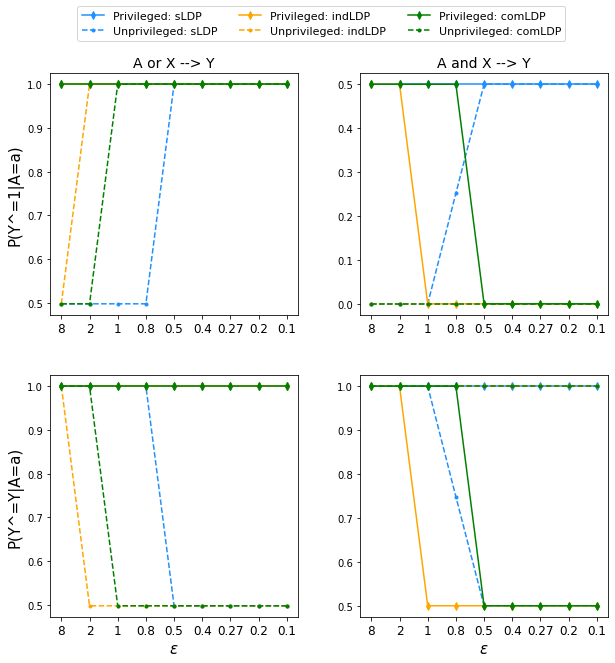

In [63]:
#lst_eps = [8,2,1,0.84,0.5,0.40,0.27,0.1]
lst_eps = [8,2,1,0.8,0.5,0.40,0.27,0.2,0.1]
Make_subplots(lst_eps,'Results')

In [ ]:
def Make_subplots(lst_eps,dataset_name):
   
    
    fig2, ax2 = plt.subplots(2, 3, figsize=(15, 8), sharey='none')
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    
    #Fairness metric 1: conditional Statistical Parity
    # Case1-Dist1:
    ax2[0,0].axhline(y=np_sp_maj, color='dodgerblue', label = 'Privileged: No LDP')
    ax2[0,0].axhline(y=np_sp_min, color='orange', linestyle='dashed',label = 'Unprivileged: No LDP')
    ax2[0,0].plot(sldp_sp_maj, label = 'Privileged: sLDP', color='dodgerblue',linestyle='solid', marker='d',markersize=5)
    ax2[0,0].plot(sldp_sp_min, label = 'Unprivileged: sLDP', color='orange',linestyle='dashed', marker='.')
    ax2[0,0].set_ylabel('P(Y^=1|A=a)',fontsize=15)
    # Case1-Dist5:
    ax2[0,1].axhline(y=np_sp_maj5, color='dodgerblue')
    ax2[0,1].axhline(y=np_sp_min5, color='orange', linestyle='dashed')
    ax2[0,1].plot(sldp_sp_maj5, color='dodgerblue',linestyle='solid', marker='d',markersize=5)
    ax2[0,1].plot(sldp_sp_min5, color='orange',linestyle='dashed', marker='.')
    #ax2[0,1].set_ylabel('P(Y^=1|A=a)',fontsize=15)
    # Case2:
    ax2[0,2].axhline(y=np_sp_maj2, color='dodgerblue')
    ax2[0,2].axhline(y=np_sp_min2, color='orange', linestyle='dashed')
    ax2[0,2].plot(sldp_sp_maj2, color='dodgerblue',linestyle='solid', marker='d',markersize=5)
    ax2[0,2].plot(sldp_sp_min2, color='orange',linestyle='dashed', marker='.')
    #ax2[0,2].set_ylabel('P(Y^=1|A=a)',fontsize=15)
    


    for i in range(2):
            for j in range(3):
                ax2[i, j].set_xticks(range(len(lst_eps)))        
                ax2[i, j].set_xticklabels(lst_eps,fontsize=12)
                ax2[0, j].set_xlabel('$\epsilon$', fontsize=15)
    
    ax2[0, 0].legend(loc = 'upper right',bbox_to_anchor = (2.3,1.5) ,ncol=2,fontsize='12')        
    # save the plot as a file

    fig2.savefig('Plots/IPoP/'+ dataset_name +'.pdf',dpi=100,bbox_inches='tight')
    
    return fig2.show()